In [4]:
# !pip install opendatasets --quiet
# import opendatasets as od
# od.download("https://www.kaggle.com/datasets/puneet6060/intel-image-classification")

In [5]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
image_path =[]
labels = []

In [7]:
for i in os.listdir("/kaggle/input/datasets/ganeshbabu2004/labeled-scenery-images/intel_image_classification/with_labels"):
    for label in os.listdir(f"/kaggle/input/datasets/ganeshbabu2004/labeled-scenery-images/intel_image_classification/with_labels/{i}"):
        for image in os.listdir(f"/kaggle/input/datasets/ganeshbabu2004/labeled-scenery-images/intel_image_classification/with_labels/{i}/{label}"):
            image_path.append(f"/kaggle/input/datasets/ganeshbabu2004/labeled-scenery-images/intel_image_classification/with_labels/{i}/{label}/{image}")
            labels.append(label)
            

In [8]:
df = pd.DataFrame({'image_path':image_path,'labels':labels})

In [9]:
df.head()

,image_path,labels
0,/kaggle/input/datasets/ganeshbabu2004/labeled-...,mountain
1,/kaggle/input/datasets/ganeshbabu2004/labeled-...,mountain
2,/kaggle/input/datasets/ganeshbabu2004/labeled-...,mountain
3,/kaggle/input/datasets/ganeshbabu2004/labeled-...,mountain
4,/kaggle/input/datasets/ganeshbabu2004/labeled-...,mountain


In [10]:
test,train = train_test_split(df,test_size=0.7,random_state=1)
val,test = train_test_split(test,test_size=0.5,random_state=1)

In [11]:
len(train),len(test),len(val)

(11926, 2555, 2555)

In [12]:
train.head()

,image_path,labels
14537,/kaggle/input/datasets/ganeshbabu2004/labeled-...,mountain
13276,/kaggle/input/datasets/ganeshbabu2004/labeled-...,glacier
6055,/kaggle/input/datasets/ganeshbabu2004/labeled-...,buildings
12428,/kaggle/input/datasets/ganeshbabu2004/labeled-...,glacier
14425,/kaggle/input/datasets/ganeshbabu2004/labeled-...,mountain


## lets reset the index

In [13]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
val = val.reset_index(drop=True)

In [14]:
train.head()

,image_path,labels
0,/kaggle/input/datasets/ganeshbabu2004/labeled-...,mountain
1,/kaggle/input/datasets/ganeshbabu2004/labeled-...,glacier
2,/kaggle/input/datasets/ganeshbabu2004/labeled-...,buildings
3,/kaggle/input/datasets/ganeshbabu2004/labeled-...,glacier
4,/kaggle/input/datasets/ganeshbabu2004/labeled-...,mountain


In [15]:
train['labels'].value_counts()

labels
mountain     2132
glacier      2122
street       2019
sea          1929
forest       1912
buildings    1812
Name: count, dtype: int64

In [16]:
label_encoder = LabelEncoder()
label_encoder.fit(train['labels'])
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])


In [17]:
class CustomImageDataset(Dataset):
    def __init__(self,df,transform):
        self.df = df
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(df['labels'])).to(device)
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        image_path = self.df.iloc[idx,0]
        label = self.labels[idx]
        image = Image.open(image_path)
        if self.transform:
            image = (self.transform(image)/255.0).to(device)
            return image,label
    

In [18]:
train_dataset = CustomImageDataset(df=train,transform=transform)
test_dataset = CustomImageDataset(df=test,transform=transform)
val_dataset = CustomImageDataset(df=val,transform=transform)

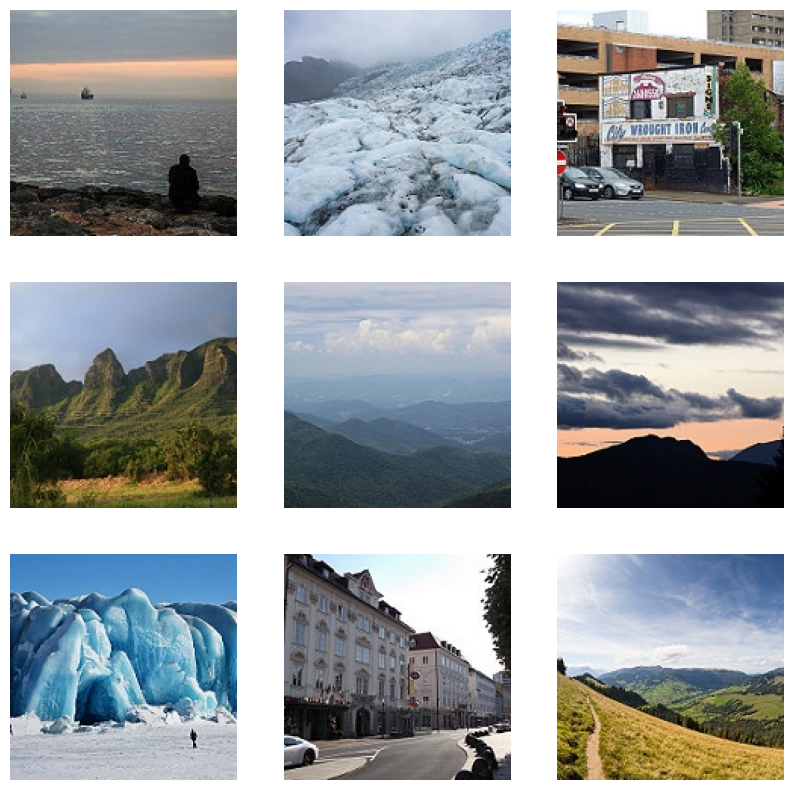

In [19]:
n_rows = 3
n_cols = 3

f, axarr= plt.subplots(n_rows,n_cols,figsize=(10,10))

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert('RGB')
    axarr[row, col].imshow(image)
    axarr[row, col].axis('off')

plt.show()

In [20]:
LR = 1e-3
BATCH_SIZE = 8
EPOCHS = 15


In [21]:
train_loader = DataLoader(train_dataset,batch_size = BATCH_SIZE,shuffle = True)
val_loader = DataLoader(val_dataset,batch_size = BATCH_SIZE,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size = BATCH_SIZE,shuffle = True)

In [22]:
googlenet_model = models.googlenet(weights = 'DEFAULT')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 186MB/s]


In [23]:
for param in googlenet_model.parameters():
    param.requires_grad = True

In [24]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [25]:
num_class = train['labels'].unique().shape[0]
num_class

6

## the googlenet model has 1000 classes we only need 6

In [26]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features,num_class)
googlenet_model.fc

Linear(in_features=1024, out_features=6, bias=True)

In [27]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [28]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(),lr = LR)

total_loss_train_plot =[]
total_acc_train_plot =[]

for epoch in range(EPOCHS):
    total_acc_train =0
    total_loss_train =0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = googlenet_model(inputs)
        train_loss = loss_fun(outputs,labels)
        total_loss_train += train_loss.item()
        
        train_loss.backward()

        train_acc = (torch.argmax(outputs,axis=1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    total_loss_train_plot.append(round(total_loss_train/1000,4))
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100,4))
    print(f"Epoch:{epoch}/{EPOCHS}, Train Loss: {round(total_loss_train/1000,4)}, Train Accuracy:{round(total_acc_train/train_dataset.__len__()*100,4)}%")

Epoch:0/15, Train Loss: 1.4126, Train Accuracy:65.0428%
Epoch:1/15, Train Loss: 1.0298, Train Accuracy:75.239%
Epoch:2/15, Train Loss: 0.8664, Train Accuracy:79.2135%
Epoch:3/15, Train Loss: 0.7572, Train Accuracy:82.2573%
Epoch:4/15, Train Loss: 0.6873, Train Accuracy:84.0013%
Epoch:5/15, Train Loss: 0.6136, Train Accuracy:85.7538%
Epoch:6/15, Train Loss: 0.5537, Train Accuracy:86.869%
Epoch:7/15, Train Loss: 0.5102, Train Accuracy:87.7411%
Epoch:8/15, Train Loss: 0.4538, Train Accuracy:89.3091%
Epoch:9/15, Train Loss: 0.4403, Train Accuracy:90.1308%
Epoch:10/15, Train Loss: 0.3725, Train Accuracy:91.3802%
Epoch:11/15, Train Loss: 0.3421, Train Accuracy:92.0174%
Epoch:12/15, Train Loss: 0.3253, Train Accuracy:92.1432%
Epoch:13/15, Train Loss: 0.2945, Train Accuracy:93.0404%
Epoch:14/15, Train Loss: 0.2587, Train Accuracy:94.1053%


In [41]:
with torch.no_grad():
    total_acc_test =0
    total_loss_test =0

    for inputs, labels in val_loader:
        prediction = googlenet_model(inputs)
        acc = (torch.argmax(prediction,axis=1) == labels).sum().item()
        total_acc_test += acc

        train_loss = loss_fun(prediction,labels)
        total_loss_test += train_loss.item()

In [44]:
print("test Accuracy",round(total_acc_test/val_dataset.__len__()*100,2))
print("test loss",round(total_loss_test/1000,4))

test Accuracy 86.46
test loss 0.1374


## saving the model with accuracy of 88.1%

In [39]:
torch.save(googlenet_model.state_dict(), "/kaggle/working/model.pth")


## visualizeing the performance

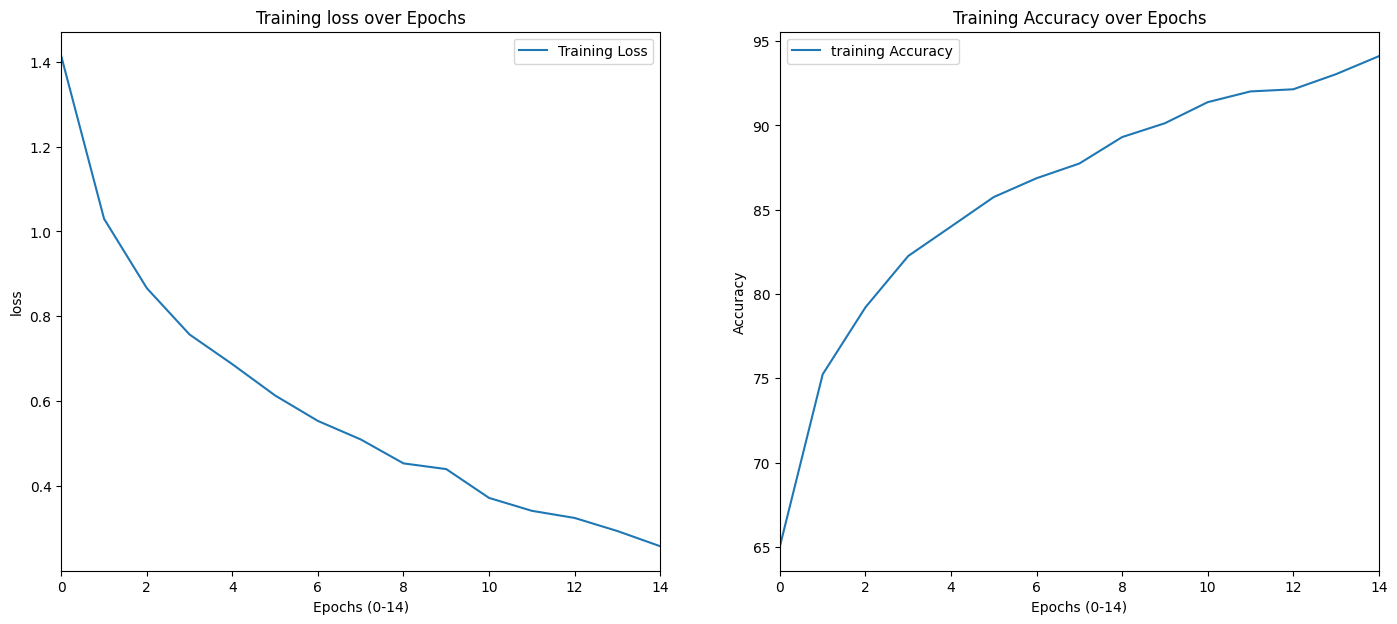

In [32]:
fig, axs = plt.subplots(nrows = 1, ncols = 2,figsize = (17,7))

axs[0].plot(total_loss_train_plot,label= 'Training Loss')

axs[0].set_title("Training loss over Epochs")
axs[0].set_xlabel('Epochs (0-14)')
axs[0].set_ylabel('loss')
axs[0].set_xlim(0, 14)
axs[0].legend()

axs[1].plot(total_acc_train_plot,label= 'training Accuracy')
axs[1].set_title("Training Accuracy over Epochs")
axs[1].set_xlabel("Epochs (0-14)")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlim(0, 14)
axs[1].legend()

plt.show()

In [40]:
# googlenet_model.load_state_dict(torch.load("/kaggle/input/your-notebook-version/model.pth"))
# googlenet_model.eval()

In [58]:
def predict_image(image_path):
  image = Image.open(image_path).convert("RGB")
  image_display = image.copy() # Create a copy for displaying
  image = transform(image).to(device)
  output = googlenet_model(image.unsqueeze(0))
  output = torch.argmax(output,axis = 1)

  plt.figure(figsize=(3,3)) # Set the figure size to make the image smaller
  plt.imshow(image_display) # Display the original image
  plt.axis('off') # Hide axes
  plt.show()

  return "the above image is",label_encoder.inverse_transform(output.cpu().detach().numpy())[0]

torch.Size([3, 128, 128])


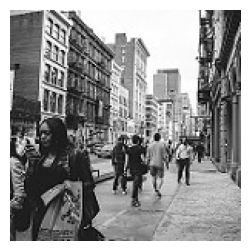

('the above image is', 'street')

In [35]:
predict_image("/kaggle/input/datasets/ganeshbabu2004/labeled-scenery-images/intel_image_classification/seg_pred/seg_pred/10375.jpg")

torch.Size([3, 128, 128])


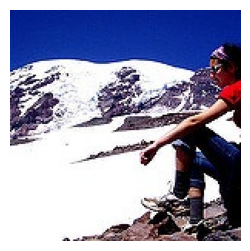

('the above image is', 'glacier')

In [45]:
predict_image("/kaggle/input/datasets/ganeshbabu2004/labeled-scenery-images/intel_image_classification/with_labels/seg_test/mountain/20116.jpg")

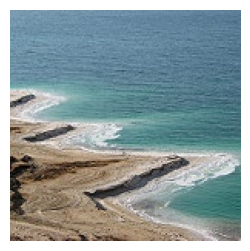

('the above image is', 'sea')

In [65]:
predict_image("/kaggle/input/datasets/ganeshbabu2004/labeled-scenery-images/intel_image_classification/with_labels/seg_train/sea/10115.jpg")

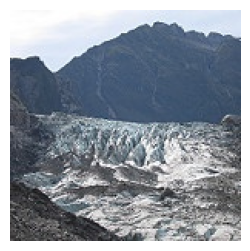

('the above image is', 'glacier')

In [64]:
predict_image("/kaggle/input/datasets/ganeshbabu2004/labeled-scenery-images/intel_image_classification/with_labels/seg_train/glacier/10033.jpg")

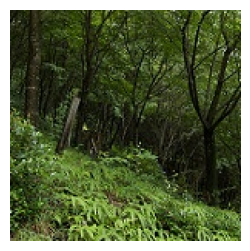

('the above image is', 'forest')

In [72]:
predict_image("/kaggle/input/datasets/ganeshbabu2004/labeled-scenery-images/intel_image_classification/with_labels/seg_train/forest/10007.jpg")

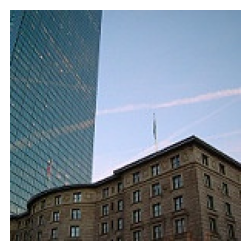

('the above image is', 'buildings')

In [85]:
predict_image("/kaggle/input/datasets/ganeshbabu2004/labeled-scenery-images/intel_image_classification/with_labels/seg_train/buildings/10151.jpg")